In [ ]:
from typing import TypedDict, Annotated, List, Literal, Sequence, Optional, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel
import json
import markdown

from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langsmith import traceable

import matplotlib.pyplot as plt
import base64
from io import BytesIO
import numpy as np
from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

# Marketing Chatbot

In [9]:
class ResearchState(TypedDict):
    message: Annotated[List[BaseMessage], add_messages]

    product_description: Optional[str]
    product_type: Optional[str]
    target_market_region: Optional[str]
    target_customer_profile: Optional[str]
    problem_to_solve: Optional[str]
    business_goal: Optional[str]
    budget: Optional[str]
    timeline: Optional[str]
    your_unique_point: Optional[str]
    competitors: Optional[str]
    
    strategy_content: Optional[str]
    market_analysis: Optional[str]
    gantt_chart: Optional[str]
    gantt_tasks: Optional[List[dict]]

    information_needed: List[str]
    informationisEnough: Optional[bool]
    errors: Annotated[List[str], add_messages]
    final_report: Optional[str]
    current_question: Optional[str]
    temp_answer: Optional[str]

# Helper Functions

In [49]:
# Helper Functions
# May use LLM to generate questions based on the information needed
def get_field_question(field: str) -> str:
    """Get question for each field"""
    questions = {
        "product_description": "Bạn có thể mô tả ngắn gọn về sản phẩm không?",
        "product_type": "Loại sản phẩm của bạn là gì?",
        "target_market_region": "Bạn muốn nhắm đến thị trường ở khu vực nào?",
        "target_customer_profile": "Khách hàng lý tưởng của bạn là ai?",
        "problem_to_solve": "Sản phẩm giải quyết vấn đề gì cho khách hàng?",
        "business_goal": "Mục tiêu marketing của bạn là gì?",
        "budget": "Ngân sách marketing bạn dự kiến là bao nhiêu?",
        "timeline": "Bạn muốn thực hiện chiến dịch trong khoảng thời gian nào?",
        "your_unique_point": "Điểm khác biệt chính của bạn là gì?",
        "competitors": "Bạn có biết đối thủ cạnh tranh nào trong lĩnh vực này không?"
    }
    return questions.get(field, f"Nhập thông tin cho: {field}")

def generate_report(state: ResearchState) -> str:
    """Generate final comprehensive report"""
    base64_image = state.get("gantt_chart")

    report = f"""
=== BÁO CÁO PHÂN TÍCH KINH DOANH ===

I. THÔNG TIN SẢN PHẨM:
- Mô tả: {state.get('product_description')}
- Loại sản phẩm: {state.get('product_type')}
- Thị trường: {state.get('target_market_region')}
- Khách hàng: {state.get('target_customer_profile')}
- Vấn đề giải quyết: {state.get('problem_to_solve')}

II. CHIẾN LƯỢC KINH DOANH:\n
{state.get('strategy_content')}

III. PHÂN TÍCH THỊ TRƯỜNG:\n
{state.get('market_analysis')}

IV. THỜI GIAN THỰC HIỆN:\n
{state.get('gantt_chart')}

"""
    return display(Markdown(report))

api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

llm = initialize_llm()

# Nodes

In [56]:
# Node Functions to get information
def ask_question_node(state: ResearchState) -> ResearchState:
    """Ask next question"""
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state
    
    field = state["information_needed"][0]
    question = get_field_question(field)
    state["current_question"] = question
    print(f"\n{question}")
    return state

def process_answer_node(state: ResearchState) -> ResearchState:
    """Process user answer and update state"""
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state
    
    # Get current field and user's answer from the last message
    field = state["information_needed"][0]
    
    # Get user's answer
    user_answer = state.get("temp_answer", "")
    
    if user_answer:
        # Match answer to the corresponding state field
        state[field] = user_answer
        print(f"Saved {field}: {user_answer}")
        
        # Remove completed field from needed list
        new_list = []
        for f in state["information_needed"]:
            if f != field:
                new_list.append(f)

        state["information_needed"] = new_list

        # Reset temporary answer
        state["temp_answer"] = ""
    
    if not state["information_needed"]:
        state["informationisEnough"] = True
    
    return state

def final_report_node(state: ResearchState) -> ResearchState:
    """Generate and display final report"""
    report = generate_report(state)
    state["final_report"] = report
    print(report)
    return state

def should_continue(state: ResearchState) -> str:
    """Decide next step"""
    return "analyze" if state.get("informationisEnough") else "ask"

# Analyze Nodes
def strategy_analysis_node(state: ResearchState) -> ResearchState:
    """Create business strategy and extract tasks for Gantt chart"""
    print("Phân tích chiến lược kinh doanh")
    
    # Get strategy content
    strategy_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sản phẩm sau, hãy tạo nội dung chiến lược kinh doanh chi tiết:

    Sản phẩm: {product_description}
    Loại: {product_type}  
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Vấn đề giải quyết: {problem_to_solve}
    Mục tiêu: {business_goal}
    Ngân sách: {budget}
    Thời gian: {timeline}
    Điểm khác biệt: {unique_point}
    Đối thủ: {competitors}

    Hãy tạo chiến lược logic bao gồm:
    1. Định vị sản phẩm
    2. Chiến lược tiếp thị
    3. Kế hoạch phát triển
    4. Chiến lược cạnh tranh
    5. Roadmap thực hiện chi tiết

    Trả lời bằng tiếng Việt, chi tiết và chuyên nghiệp. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng
    """)
    # Viết dưới dạng HTML với các tiêu đề rõ ràng.

    strategy_messages = strategy_prompt.format_messages(
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        target_market_region=state.get('target_market_region'),
        target_customer_profile=state.get('target_customer_profile'),
        problem_to_solve=state.get('problem_to_solve'),
        business_goal=state.get('business_goal'),
        budget=state.get('budget'),
        timeline=state.get('timeline'),
        unique_point=state.get('your_unique_point'),
        competitors=state.get('competitors')
    )
    
    strategy_result = llm.invoke(strategy_messages)
    state["strategy_content"] = strategy_result.content
    
    print("Hoàn thành phân tích chiến lược")
    return state

def gantt_task_extract_node(state: ResearchState) -> ResearchState:
    """Extract tasks for Gantt chart from strategy analysis"""
    
    # Extract tasks for Gantt chart
    tasks_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin dự án và thời gian thực hiện, hãy tạo danh sách tasks cho biểu đồ Gantt:

    Thời gian thực hiện: {timeline}
    Sản phẩm: {product_description}
    Loại sản phẩm: {product_type}
    Ngân sách: {budget}
    Mục tiêu: {business_goal}

    Trả về CHÍNH XÁC format JSON sau, không thêm text gì khác:
    [
        {{"name": "Tên nhiệm vụ 1", "start": 0, "duration": 2}},
        {{"name": "Tên nhiệm vụ 2", "start": 1, "duration": 3}},
        {{"name": "Tên nhiệm vụ 3", "start": 3, "duration": 2}}
    ]

    Trong đó:
    - name: Tên nhiệm vụ bằng tiếng Việt
    - start: Tháng bắt đầu (từ 0)
    - duration: Số tháng thực hiện

    Tạo 6-8 nhiệm vụ hợp lý cho dự án này. Các nhiệm vụ có thể chồng lấn về thời gian. 
    CHỈ trả về JSON, không có text thêm.
    """)
    
    tasks_messages = tasks_prompt.format_messages(
        timeline=state.get('timeline'),
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        budget=state.get('budget'),
        business_goal=state.get('business_goal')
    )
    
    tasks_result = llm.invoke(tasks_messages)
    
    try:
        
        tasks_json = tasks_result.content.strip()
        # Remove any potential markdown formatting
        if tasks_json.startswith('```'):
            tasks_json = tasks_json.split('```')[1]
            if tasks_json.startswith('json'):
                tasks_json = tasks_json[4:]
        
        tasks = json.loads(tasks_json)
        state["gantt_tasks"] = tasks
        print(f"Đã tạo {len(tasks)} nhiệm vụ cho Gantt chart")
        
    except json.JSONDecodeError as e:
        print(f"Lỗi parse JSON: {e}")

    print("Hoàn thành phân tích task Gantt")
    return state

def market_analysis_node(state: ResearchState) -> ResearchState:
    """Analyze market situation"""
    print("Phân tích tình hình thị trường")
    
    prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sau, hãy thực hiện phân tích thị trường chi tiết:

    Sản phẩm: {product_description}
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Đối thủ: {competitors}
    Ngân sách: {budget}

    Phân tích bao gồm:
    1. Quy mô và tiềm năng thị trường
    2. Xu hướng thị trường hiện tại
    3. Phân khúc khách hàng
    4. Phân tích đối thủ cạnh tranh
    5. Cơ hội và thách thức
    6. Đề xuất các từ khóa và chủ đề cần nghiên cứu thêm trên web

    Trả lời dựa trên dữ liệu thực tế và xu hướng hiện tại. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng. 
    """)
        # Viết dưới dạng HTML với các tiêu đề rõ ràng.

    messages = prompt.format_messages(
        product_description=state.get('product_description', ''),
        target_market_region=state.get('target_market_region', ''),
        target_customer_profile=state.get('target_customer_profile', ''),
        competitors=state.get('competitors', ''),
        budget=state.get('budget', '')
    )
    
    result = llm.invoke(messages)
    state["market_analysis"] = result.content
    return state

def create_gantt_chart_node(state: ResearchState) -> ResearchState:
    """Create Gantt chart using tasks from strategy analysis"""
    print("Tạo biểu đồ Gantt")
    
    try:
        # Get tasks from strategy analysis
        tasks = state.get("gantt_tasks", [])
        
        if not tasks:
            print("Không có tasks từ strategy analysis")
            state["gantt_chart"] = "Lỗi: Không có dữ liệu tasks"
            return state
        
        fig, ax = plt.subplots(figsize=(14, len(tasks) + 2))
        
        # Colors for different tasks
        colors = plt.cm.Set3(np.linspace(0, 1, len(tasks)))
        
        # Plot each task
        for i, (task, color) in enumerate(zip(tasks, colors)):
            name = task.get('name', f'Task {i+1}')
            start = task.get('start', 0)
            duration = task.get('duration', 1)
            
            # Create bar for task
            ax.barh(i, duration, left=start, color=color, alpha=0.7, height=0.6)
            
            # Add task name inside or beside the bar
            text_x = start + duration/2 if duration > 2 else start + duration + 0.1
            ax.text(text_x, i, name, ha='center' if duration > 2 else 'left', 
                   va='center', fontweight='bold', fontsize=10)
            
            # Add duration info
            ax.text(start + duration + 0.5, i, f'{duration}th', 
                   ha='left', va='center', fontsize=8, style='italic')
        
        # Customize chart
        ax.set_xlabel('Tháng', fontsize=12, fontweight='bold')
        ax.set_ylabel('Nhiệm vụ', fontsize=12, fontweight='bold')
        ax.set_title('Biểu đồ Gantt - Kế hoạch thực hiện dự án', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Set y-axis
        ax.set_yticks(range(len(tasks)))
        ax.set_yticklabels([f'Task {i+1}' for i in range(len(tasks))])
        ax.invert_yaxis()  # Top to bottom
        
        # Set x-axis
        max_time = max([task.get('start', 0) + task.get('duration', 1) for task in tasks])
        ax.set_xlim(0, max_time + 2)
        ax.set_xticks(range(0, max_time + 3))
        
        # Add grid
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.grid(axis='y', alpha=0.1)
        
        # Add timeline info
        timeline_info = state.get('timeline', 'Không xác định')
        ax.text(0.02, 0.98, f'Tổng thời gian dự án: {timeline_info}', 
               transform=ax.transAxes, fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
               verticalalignment='top')
        
        # plt.tight_layout()
        # chart_path = 'gantt_chart.png'
        # plt.savefig(chart_path, dpi=300, bbox_inches='tight', 
        #            facecolor='white', edgecolor='none')
        # plt.close()
        
        # state["gantt_chart"] = chart_path

        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        buf.seek(0)

        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        state["gantt_chart_base64"] = img_base64
        
        print(f"Đã tạo biểu đồ Gantt")
        
    except Exception as e:
        state["gantt_chart"] = f"Lỗi tạo biểu đồ Gantt: {str(e)}"
        print(f"Lỗi tạo biểu đồ Gantt: {e}")
    
    return state
    
    

# Graph

In [ ]:
graph_builder = StateGraph(ResearchState)

# Add nodes
graph_builder.add_node("ask", ask_question_node)
graph_builder.add_node("process", process_answer_node)

# Analysis nodes (only 3 as requested)
graph_builder.add_node("analyze", strategy_analysis_node)
graph_builder.add_node("gantt_task_extract", gantt_task_extract_node)
graph_builder.add_node("market", market_analysis_node)
graph_builder.add_node("gantt_chart", create_gantt_chart_node)

graph_builder.add_node("final_report", final_report_node)

# Add edges
graph_builder.set_entry_point("ask")
graph_builder.add_edge("ask", "process")
graph_builder.add_conditional_edges("process", should_continue, {
    "ask": "ask",
    "analyze": "analyze"
})

# Analysis chain (simplified to 3 nodes)
graph_builder.add_edge("analyze", "gantt_task_extract")
graph_builder.add_edge("gantt_task_extract", "market")
graph_builder.add_edge("market", "gantt_chart")
graph_builder.add_edge("gantt_chart", "final_report")

graph_builder.add_edge("final_report", END)

# Compile graph with interrupt
graph = graph_builder.compile(
    checkpointer=MemorySaver(),
    interrupt_after=["ask"]
)

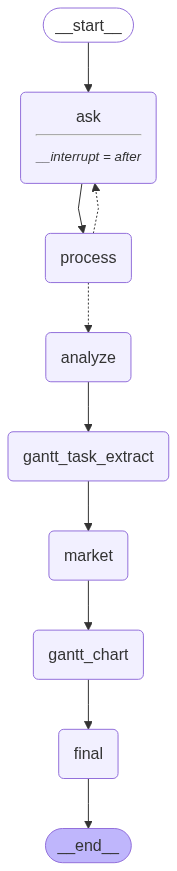

In [59]:
graph

# Conversation

In [58]:
config = {"configurable": {"thread_id": "research"}}

# Initial state
initial_state = {
    "message": [],
    "information_needed": [
        "product_description", "product_type", "target_market_region",
        "target_customer_profile", "problem_to_solve", "business_goal", 
        "budget", "timeline", "your_unique_point", "competitors"
    ],
    "informationisEnough": False,
    "errors": [],
    "current_question": None,
    "final_report": None,
    "temp_answer": None,

    "strategy_content": None,
    "market_analysis": None,
    "gantt_tasks": None,
    "gantt_chart": None
}

# Start conversation
graph.invoke(initial_state, config=config)

# Continue until done
while True:
    # Check if done
    snapshot = graph.get_state(config)
    if snapshot.values.get("informationisEnough", False):
        break
        
    try:
        answer = input("Trả lời: ").strip()
        if answer.lower() in ['quit', 'exit']:
            break
        if answer:
            # Store answer in temporary field for the node to process
            current_state = snapshot.values
            current_state["temp_answer"] = answer
            
            # Continue conversation
            graph.update_state(config, current_state)
            graph.invoke(None, config=config)
    except KeyboardInterrupt:
        print("\nSTOP")
        break


Bạn có thể mô tả ngắn gọn về sản phẩm không?
Saved product_description: Phần mềm quản lý nhà hàng thông minh

Loại sản phẩm của bạn là gì?
Saved product_type: SaaS

Bạn muốn nhắm đến thị trường ở khu vực nào?
Saved target_market_region: Việt Nam

Khách hàng lý tưởng của bạn là ai?
Saved target_customer_profile: Nhà hàng và quán cà phê

Sản phẩm giải quyết vấn đề gì cho khách hàng?
Saved problem_to_solve: Tăng tương tác khách hàng qua mạng xã hội lên 2000 lượt theo dõi

Mục tiêu marketing của bạn là gì?
Saved business_goal: Đạt 500,000 người dùng trong 2 năm

Ngân sách marketing bạn dự kiến là bao nhiêu?
Saved budget: 2 tỷ VND

Bạn muốn thực hiện chiến dịch trong khoảng thời gian nào?
Saved timeline: 6 tháng

Điểm khác biệt chính của bạn là gì?
Saved your_unique_point: Giao diện trực quan, tích hợp AI gợi ý marketing

Bạn có biết đối thủ cạnh tranh nào trong lĩnh vực này không?
Saved competitors: KiotViet, iPOS
Phân tích chiến lược kinh doanh
Hoàn thành phân tích chiến lược
Đã tạo 8 nh


=== BÁO CÁO PHÂN TÍCH KINH DOANH ===

I. THÔNG TIN SẢN PHẨM:
- Mô tả: Phần mềm quản lý nhà hàng thông minh
- Loại sản phẩm: SaaS
- Thị trường: Việt Nam
- Khách hàng: Nhà hàng và quán cà phê
- Vấn đề giải quyết: Tăng tương tác khách hàng qua mạng xã hội lên 2000 lượt theo dõi

II. CHIẾN LƯỢC KINH DOANH:

## Chiến Lược Kinh Doanh Phần Mềm Quản Lý Nhà Hàng Thông Minh (SaaS)

**1. Định Vị Sản Phẩm:**

*   **Tuyên bố định vị:** Phần mềm quản lý nhà hàng thông minh [Tên sản phẩm] là giải pháp SaaS toàn diện, giúp nhà hàng và quán cà phê tại Việt Nam tối ưu hóa vận hành, tăng tương tác khách hàng trên mạng xã hội và bứt phá doanh thu nhờ giao diện trực quan, dễ sử dụng và tích hợp AI hỗ trợ marketing thông minh.
*   **Giá trị cốt lõi:**
    *   **Dễ sử dụng:** Giao diện trực quan, thân thiện với người dùng, giảm thiểu thời gian đào tạo.
    *   **Tăng tương tác khách hàng:** Tích hợp sâu với mạng xã hội, hỗ trợ các chiến dịch marketing hiệu quả.
    *   **Tối ưu vận hành:** Quản lý toàn diện từ order, thanh toán, kho, nhân viên đến báo cáo.
    *   **Marketing thông minh:** AI gợi ý các chiến dịch marketing phù hợp với từng đối tượng khách hàng.
*   **Đối tượng mục tiêu:**
    *   Nhà hàng quy mô vừa và nhỏ (5-50 nhân viên).
    *   Quán cà phê có nhu cầu quản lý chuyên nghiệp và tăng tương tác khách hàng.
    *   Các chuỗi nhà hàng, quán cà phê đang tìm kiếm giải pháp quản lý tập trung.

**2. Chiến Lược Tiếp Thị:**

*   **Mục tiêu:**
    *   Tăng nhận diện thương hiệu và thu hút khách hàng tiềm năng.
    *   Chuyển đổi khách hàng tiềm năng thành người dùng trả phí.
    *   Xây dựng cộng đồng người dùng trung thành.
*   **Kênh tiếp thị:**
    *   **Digital Marketing (70% ngân sách):**
        *   **SEO:** Tối ưu hóa website và nội dung để tăng thứ hạng trên Google cho các từ khóa liên quan đến quản lý nhà hàng, phần mềm quản lý quán cà phê, v.v.
        *   **SEM (Google Ads):** Chạy quảng cáo tìm kiếm để tiếp cận khách hàng đang tìm kiếm giải pháp quản lý nhà hàng.
        *   **Social Media Marketing (Facebook, Instagram, TikTok):**
            *   Xây dựng nội dung hấp dẫn, chia sẻ kiến thức về quản lý nhà hàng, case study thành công.
            *   Chạy quảng cáo nhắm mục tiêu đến chủ nhà hàng, quản lý nhà hàng.
            *   Tổ chức minigame, giveaway để tăng tương tác và thu hút người theo dõi.
        *   **Content Marketing:**
            *   Blog: Viết bài về các chủ đề liên quan đến quản lý nhà hàng, marketing nhà hàng, xu hướng ẩm thực.
            *   Ebook, infographic: Tạo nội dung giá trị để thu hút khách hàng tiềm năng và thu thập thông tin liên hệ.
            *   Video: Tạo video hướng dẫn sử dụng phần mềm, phỏng vấn khách hàng thành công.
        *   **Email Marketing:** Gửi email giới thiệu sản phẩm, ưu đãi đặc biệt, thông báo cập nhật tính năng mới.
    *   **Offline Marketing (30% ngân sách):**
        *   **Tham gia hội chợ, triển lãm ngành F&B:** Giới thiệu sản phẩm, kết nối với khách hàng tiềm năng.
        *   **Tổ chức workshop, seminar:** Chia sẻ kiến thức về quản lý nhà hàng, giới thiệu giải pháp phần mềm.
        *   **Hợp tác với các đối tác trong ngành:** Nhà cung cấp nguyên liệu, thiết bị nhà bếp, v.v.
*   **Thông điệp truyền thông:**
    *   Tập trung vào lợi ích mà sản phẩm mang lại cho khách hàng: Tiết kiệm thời gian, tăng doanh thu, cải thiện trải nghiệm khách hàng.
    *   Nhấn mạnh sự khác biệt của sản phẩm: Giao diện trực quan, tích hợp AI, hỗ trợ marketing thông minh.
    *   Sử dụng ngôn ngữ gần gũi, dễ hiểu, phù hợp với đối tượng mục tiêu.
*   **Chương trình khuyến mãi:**
    *   Dùng thử miễn phí 14-30 ngày.
    *   Giảm giá cho khách hàng đăng ký sớm.
    *   Ưu đãi đặc biệt cho khách hàng giới thiệu bạn bè.
    *   Gói dịch vụ tùy chỉnh theo nhu cầu của từng khách hàng.

**3. Kế Hoạch Phát Triển:**

*   **Phát triển sản phẩm:**
    *   **Giai đoạn 1 (6 tháng):** Tập trung vào hoàn thiện các tính năng cốt lõi: Quản lý order, thanh toán, kho, nhân viên, báo cáo.
    *   **Giai đoạn 2 (6-12 tháng):** Phát triển các tính năng nâng cao: Tích hợp với các nền tảng giao đồ ăn trực tuyến, quản lý khách hàng thân thiết, phân tích dữ liệu.
    *   **Giai đoạn 3 (12-24 tháng):** Phát triển các tính năng AI: Gợi ý chiến dịch marketing, dự đoán nhu cầu khách hàng, tối ưu hóa chi phí.
*   **Mở rộng thị trường:**
    *   **Giai đoạn 1 (6 tháng):** Tập trung vào các thành phố lớn: Hà Nội, TP.HCM, Đà Nẵng.
    *   **Giai đoạn 2 (6-12 tháng):** Mở rộng sang các tỉnh thành khác.
    *   **Giai đoạn 3 (12-24 tháng):** Nghiên cứu thị trường và khả năng mở rộng sang các nước lân cận.
*   **Xây dựng đội ngũ:**
    *   Tuyển dụng nhân viên có kinh nghiệm trong lĩnh vực phần mềm, F&B, marketing.
    *   Đào tạo nhân viên về sản phẩm, kỹ năng bán hàng, chăm sóc khách hàng.
    *   Xây dựng văn hóa làm việc chuyên nghiệp, sáng tạo, hướng đến khách hàng.

**4. Chiến Lược Cạnh Tranh:**

*   **Phân tích đối thủ:**
    *   **KiotViet:** Ưu điểm: Thị phần lớn, nhiều tính năng. Nhược điểm: Giao diện phức tạp, ít tính năng AI.
    *   **iPOS:** Ưu điểm: Thương hiệu lâu đời, nhiều khách hàng lớn. Nhược điểm: Giá cao, ít linh hoạt.
*   **Lợi thế cạnh tranh:**
    *   **Giao diện trực quan, dễ sử dụng:** Dễ dàng tiếp cận với người dùng không chuyên về công nghệ.
    *   **Tích hợp AI gợi ý marketing:** Giúp nhà hàng tăng tương tác khách hàng và doanh thu.
    *   **Giá cả cạnh tranh:** Cung cấp các gói dịch vụ phù hợp với nhiều quy mô nhà hàng.
    *   **Dịch vụ hỗ trợ khách hàng tận tâm:** Giải đáp thắc mắc, hỗ trợ kỹ thuật nhanh chóng.
*   **Chiến lược cạnh tranh:**
    *   **Tập trung vào phân khúc nhà hàng vừa và nhỏ:** Cung cấp giải pháp phù hợp với nhu cầu và ngân sách của họ.
    *   **Xây dựng mối quan hệ tốt với khách hàng:** Lắng nghe phản hồi, cải thiện sản phẩm liên tục.
    *   **Đầu tư vào marketing và truyền thông:** Tăng nhận diện thương hiệu và thu hút khách hàng tiềm năng.
    *   **Hợp tác với các đối tác trong ngành:** Mở rộng kênh phân phối và tiếp cận khách hàng.

**5. Roadmap Thực Hiện Chi Tiết (6 tháng):**

| **Tháng** | **Hoạt động**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

III. PHÂN TÍCH THỊ TRƯỜNG:

## Phân tích Thị trường Phần mềm Quản lý Nhà hàng Thông minh tại Việt Nam

**1. Quy mô và Tiềm năng Thị trường:**

*   **Quy mô:** Thị trường F&B Việt Nam đang tăng trưởng mạnh mẽ, ước tính đạt hàng tỷ USD mỗi năm. Số lượng nhà hàng, quán cafe tăng nhanh, đặc biệt ở các thành phố lớn. Nhu cầu quản lý hiệu quả, tối ưu chi phí và nâng cao trải nghiệm khách hàng thúc đẩy nhu cầu phần mềm quản lý.
*   **Tiềm năng:** Tiềm năng tăng trưởng lớn do:
    *   **Chuyển đổi số:** Chính phủ khuyến khích chuyển đổi số trong ngành F&B.
    *   **Tăng trưởng kinh tế:** Thu nhập người dân tăng, chi tiêu cho ăn uống ngoài gia đình tăng.
    *   **Sự phát triển của công nghệ:** Ứng dụng công nghệ vào quản lý nhà hàng ngày càng phổ biến.
    *   **Mở rộng chuỗi nhà hàng:** Các chuỗi nhà hàng có nhu cầu cao về phần mềm quản lý đồng bộ.

**2. Xu hướng Thị trường Hiện tại:**

*   **Điện toán đám mây:** Phần mềm quản lý trên nền tảng đám mây ngày càng phổ biến, giúp tiết kiệm chi phí, dễ dàng truy cập và cập nhật.
*   **Tích hợp đa kênh:** Tích hợp với các kênh bán hàng online (GrabFood, Baemin, ShopeeFood), hệ thống thanh toán điện tử (VNPay, Momo), và các nền tảng marketing.
*   **Phân tích dữ liệu:** Ứng dụng AI và Big Data để phân tích dữ liệu bán hàng, hành vi khách hàng, giúp đưa ra quyết định kinh doanh chính xác.
*   **Trải nghiệm khách hàng:** Tập trung vào các tính năng giúp nâng cao trải nghiệm khách hàng như đặt bàn online, gọi món qua app, chương trình khách hàng thân thiết.
*   **Tính di động:** Ứng dụng trên điện thoại di động cho phép quản lý nhà hàng mọi lúc mọi nơi.

**3. Phân khúc Khách hàng:**

*   **Nhà hàng nhỏ lẻ:** Ưu tiên phần mềm đơn giản, dễ sử dụng, giá cả phải chăng.
*   **Chuỗi nhà hàng:** Yêu cầu phần mềm có khả năng quản lý nhiều chi nhánh, đồng bộ dữ liệu, báo cáo chi tiết.
*   **Quán cafe:** Chú trọng các tính năng quản lý menu, order, thanh toán nhanh chóng.
*   **Nhà hàng cao cấp:** Cần phần mềm có tính năng quản lý khách hàng VIP, tích hợp CRM, báo cáo chuyên sâu.
*   **Phân khúc theo khu vực:** Các thành phố lớn (Hà Nội, TP.HCM) có nhu cầu cao hơn và sẵn sàng chi trả hơn.

**4. Phân tích Đối thủ Cạnh tranh:**

*   **KiotViet:** Ưu điểm: Giá rẻ, dễ sử dụng, phù hợp với nhà hàng nhỏ lẻ. Nhược điểm: Tính năng hạn chế, ít tùy biến.
*   **iPOS:** Ưu điểm: Nhiều tính năng, phù hợp với chuỗi nhà hàng lớn. Nhược điểm: Giá cao, giao diện phức tạp.
*   **Các đối thủ khác:** Sapo FnB, CukCuk, Odoo (mảng quản lý nhà hàng), các giải pháp tự phát triển (in-house).

**Phân tích SWOT (dựa trên thông tin hiện có và giả định):**

| Yếu tố | Mô tả                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               the product/service/or the like.
*   **Strengths:**  What advantages does the product/service have?
*   **Weaknesses:** What are the disadvantages or areas for improvement?
*   **Opportunities:** What external factors could benefit the product/service?
*   **Threats:** What external factors could harm the product/service?

**5. Cơ hội và Thách thức:**

*   **Cơ hội:**
    *   **Thị trường đang phát triển:** Nhu cầu phần mềm quản lý nhà hàng ngày càng tăng.
    *   **Công nghệ mới:** Ứng dụng AI, Big Data, IoT để tạo ra các giải pháp quản lý thông minh hơn.
    *   **Hợp tác:** Hợp tác với các đối tác trong ngành F&B (nhà cung cấp nguyên liệu, dịch vụ giao đồ ăn).
    *   **Mở rộng:** Mở rộng sang các thị trường lân cận (Lào, Campuchia).
*   **Thách thức:**
    *   **Cạnh tranh gay gắt:** Nhiều đối thủ cạnh tranh, cả trong và ngoài nước.
    *   **Giá cả:** Khách hàng nhạy cảm về giá, đặc biệt là các nhà hàng nhỏ lẻ.
    *   **Thói quen:** Thay đổi thói quen quản lý truyền thống của các nhà hàng.
    *   **Bảo mật:** Đảm bảo an toàn dữ liệu cho khách hàng.
    *   **Tuyển dụng:** Tìm kiếm và giữ chân nhân tài trong lĩnh vực công nghệ.

**6. Đề xuất các từ khóa và chủ đề cần nghiên cứu thêm trên web:**

*   **Từ khóa:**
    *   Phần mềm quản lý nhà hàng
    *   Phần mềm quản lý quán cafe
    *   Phần mềm POS nhà hàng
    *   Phần mềm order nhà hàng
    *   Phần mềm quản lý kho nhà hàng
    *   Phần mềm CRM nhà hàng
    *   Phần mềm quản lý nhà hàng trên điện thoại
    *   Phần mềm quản lý nhà hàng miễn phí (để phân tích nhu cầu và kỳ vọng)
    *   KiotViet review
    *   iPOS review
    *   Xu hướng F&B Việt Nam
    *   Chuyển đổi số ngành F&B
*   **Chủ đề:**
    *   Nghiên cứu hành vi và nhu cầu của khách hàng mục tiêu.
    *   Phân tích chi tiết các đối thủ cạnh tranh (tính năng, giá cả, thị phần, điểm mạnh, điểm yếu).
    *   Tìm hiểu về các công nghệ mới trong quản lý nhà hàng (AI, Big Data, IoT).
    *   Nghiên cứu về các quy định pháp luật liên quan đến ngành F&B.
    *   Phân tích các kênh marketing hiệu quả cho phần mềm quản lý nhà hàng.
    *   Tìm hiểu về các chương trình hỗ trợ chuyển đổi số cho doanh nghiệp F&B của chính phủ.
    *   Nghiên cứu các case study thành công về ứng dụng phần mềm quản lý nhà hàng.
    *   Phân tích các chỉ số KPI quan trọng trong quản lý nhà hàng.
    *   Tìm hiểu về các giải pháp thanh toán điện tử phổ biến tại Việt Nam.
    *   Nghiên cứu về các nền tảng giao đồ ăn trực tuyến (GrabFood, Baemin, ShopeeFood).

IV. THỜI GIAN THỰC HIỆN:

None



None


# Chatbot Testing

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [53]:
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

llm = initialize_llm()

In [54]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

search = GoogleSerperAPIWrapper()
search_tool = Tool(
    name="google_search",
    func=search.run,
    description="Use this tool to search Google using Serper API.",
    return_direct=True
)

tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
memory = MemorySaver()
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[search_tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_after=["tools"],
)

config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User:")
    if user_input.lower() in ["q", "quit", "exit"]:
        print("GoodBye !!")
        break
    for event in graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

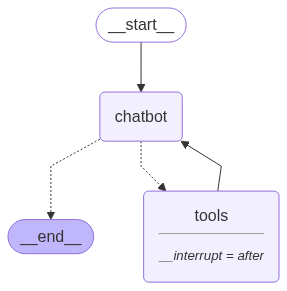

In [56]:
graph